In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import vice
import matplotlib as mpl

from scipy.stats import binned_statistic
from scipy.integrate import quad
from scipy.interpolate import interp1d, interp2d, CubicSpline
from scipy.optimize import curve_fit
import scipy

using vice version  1.4.0.dev2


/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/__init__.py:151: UserWarning: Using a pre-release of VICE
  if prerelease: warnings.warn("Using a pre-release of VICE",


In [5]:
import surp.analysis.apogee_analysis as aah
import surp.yields
from surp.analysis.plotting_utils import fig_saver, dual_plot
from surp.analysis.vice_model import vice_model
from surp.analysis import plotting_utils as pluto
from surp._globals import AGB_MODELS
plt.rcParams["figure.dpi"] = 200

In [6]:
import arya

In [7]:
df = aah.subgiants
filt = ~df["high_alpha"]
filt = ~np.isnan(df["MG_H"])
filt &= ~np.isnan(df["C_MG"])
subgiants = df[filt].copy() #low alpha is closer to equilibrium

subgiants["C_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["MG_FE_ERR"]
subgiants["N_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["N_FE_ERR"]

df_subgiants = subgiants[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances = pd.read_csv("../data_analysis/all_data.csv")
stars = pd.read_csv("../../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63], engine="python")
stars["C_MG"] =  stars["[C/H]3N"] - stars["[O/H]3N"]
stars["MG_H"] =  stars["[O/H]3N"]
stars["C_MG_ERR"] = stars["e_[C/H]3N"] + stars["e_[O/H]3N"]

df_stars = stars[["C_MG", "MG_H", "C_MG_ERR"]]

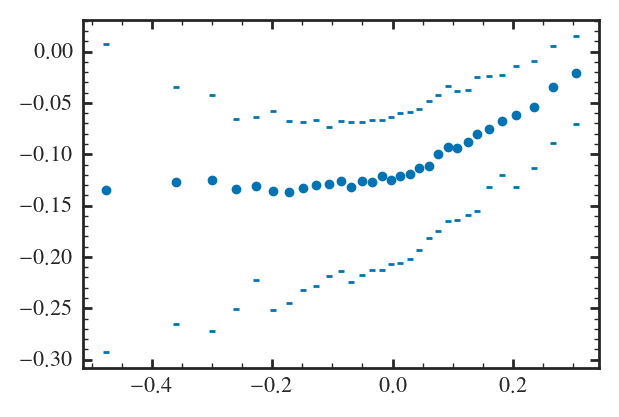

In [8]:
arya.medianplot(subgiants, x="MG_H", y="C_MG", binsize=500)

Text(0, 0.5, '[c/o]')

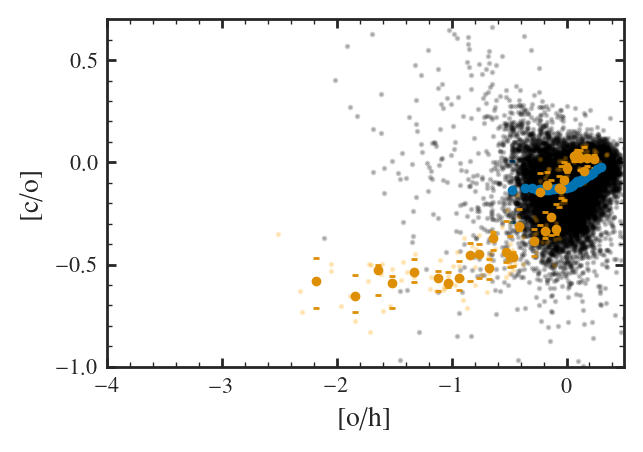

In [10]:
df_s = arya.medianplot(subgiants, x="MG_H", y="C_MG", binsize=500, stat="median", errorbar="pi", zorder=3)
plt.scatter(subgiants.O_H, subgiants["C_O"], s=1, color="k", alpha=0.2)

df_a = arya.medianplot(df_stars, x="MG_H", y="C_MG", binsize=5, stat="median", errorbar="pi", zorder=3)
plt.scatter(df_stars.MG_H, df_stars["C_MG"], s=1, color="orange", alpha=0.2)

MoverH = df_s.data.x
c_o = df_s.data.y
c_o_err = (df_s.data.y_h - df_s.data.y_l)/(df_s.data.counts)**0.5

MoverH_a = df_a.data.x
c_o_a = df_a.data.y
c_o_err_a = (df_a.data.y_h - df_a.data.y_l)/(df_a.data.counts)**0.5





plt.xlim(-4, 0.5)
plt.ylim(-1, 0.7)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

cristallo11
[ 0.00041838 -0.01759546]
[2.26051814e-05 4.09988063e-03]


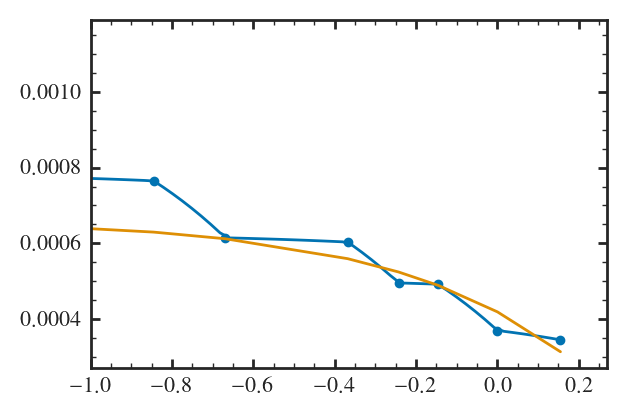

/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


karakas10
[ 0.00063821 -0.05856052]
[inf inf]


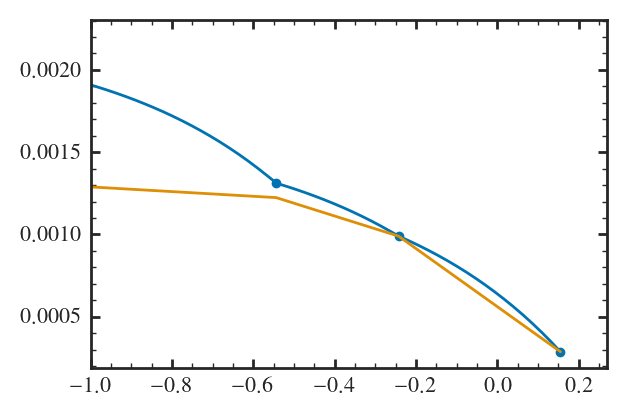

ventura13
[ 0.00029812 -0.02116209]
[0.00014075 0.00913653]


/tmp/slurmtmp.23138250/ipykernel_147503/4270792888.py:33: RuntimeWarning: invalid value encountered in sqrt
  print(np.diag(np.sqrt(covt)))


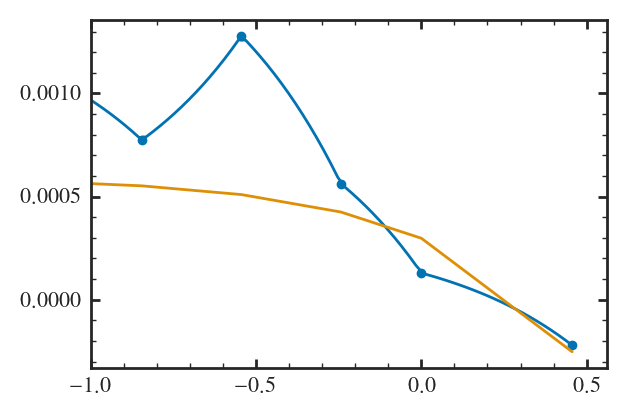

karakas16
[ 0.00051004 -0.0293396 ]
[3.65573215e-05 3.62564331e-03]


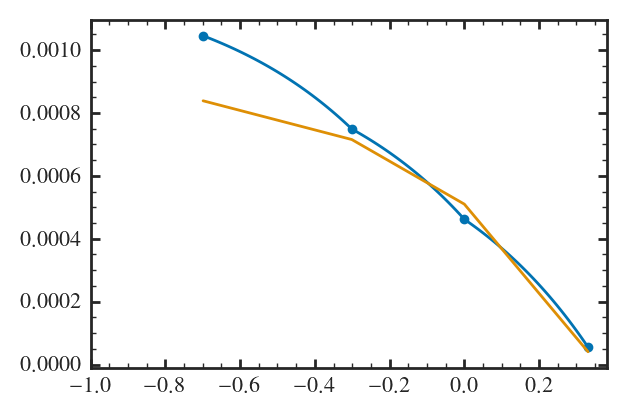

In [11]:
for study in surp._globals.AGB_MODELS:
    y1, m1, z1 = vice.yields.agb.grid("c", study=study)
    y_c_agb1 = []
    for i in range(len(z1)):
        def m_model(m):
            cs = interp1d([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
            return cs(m) * ( (m > 1.3) & (m < 6))
        norm = quad(lambda m: m*vice.imf.kroupa(m), 0.08, 120)[0]
        yc = quad(lambda m: m*m_model(m)* vice.imf.kroupa(m), 1.3, 6)[0]/norm
        y_c_agb1.append(yc)

    mh1 = np.log10(np.array(z1)/0.014)
    y_c_agb1 = np.array(y_c_agb1)

    y_agb = lambda x: interp1d(z1, y_c_agb1, fill_value="extrapolate")(0.014*10**x)

    mh_mod = np.linspace(min(mh1), max(mh1), 100)
    y_agb_mod = y_agb(mh_mod)
    
    plt.plot(mh_mod, y_agb_mod)

    plt.scatter(mh1, y_c_agb1)
    def lin(x, a, b):
        return a - 0.014*b + b*0.014*10**x
    
    filt = mh1 > -0.4
    popt, covt = curve_fit(lin, mh1[filt], y_c_agb1[filt])

    plt.plot(mh1, lin(mh1, *popt))

    print(study)
    print(popt)
    print(np.diag(np.sqrt(covt)))
    plt.xlim(-1)
    plt.show()
    

In [33]:
arya.style.set_size((4, 2*np.sqrt(2)))

In [14]:
def y_mod(x, a, b):
    return a + b*(x-0.014)

[0.00479372 0.06678607]
[2.26510909e-05 3.57103006e-03]


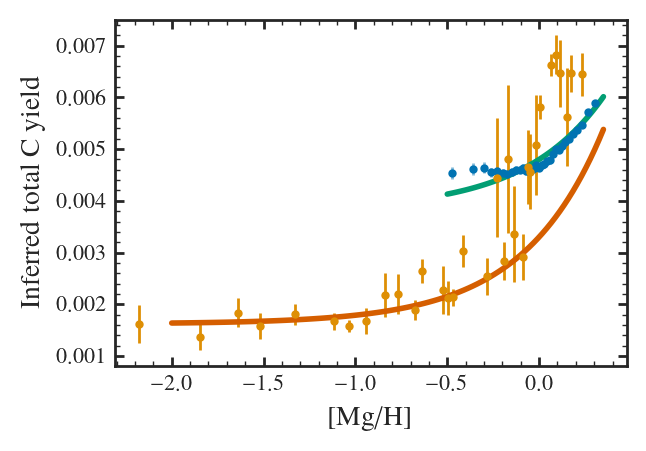

In [26]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
# parameters
y_o_cc = 0.015

y_c = y_o_cc*aah.bracket_to_abundance(c_o, "C", "O")
y_c_err = y_c * np.log(10) * c_o_err

y_c_cc = y_c - 0*2.88*y_agb(MoverH)

y_c_a = y_o_cc*aah.bracket_to_abundance(c_o_a, "C", "O")
y_err_a = y_c_a * np.log(10) * c_o_err_a


a,b,c = plt.errorbar(MoverH, y_c_cc, y_c_err, fmt="o", capsize=0, ms=2)

c[0].set_alpha(0.5)
a,b,c = plt.errorbar(MoverH_a, y_c_a, y_err_a, fmt="o", capsize=0, ms=2)


popt, covt = curve_fit(y_mod, 0.014*10**MoverH, y_c_cc, sigma=y_c_err, p0=(0.005, 0.1))


# plt.plot(fe_h, y_agb(fe_h))
x_mod = np.linspace(-3, 0.5)
print(popt)
print(np.diag(covt)**0.5)

# plt.plot(MoverH, y_mod(MoverH, *popt))
x = np.linspace(-0.5, 0.35, 100)
plt.plot(x, y_mod(0.014*10**x, 0.0048, 0.07), lw=2, label="model")

x = np.linspace(-2, 0.35, 100)

plt.plot(x, y_mod(0.014*10**x, 0.0033, 0.12), lw=2, label="model")

plt.xlabel("[Mg/H]")
#leg = plt.legend()
#leg.legendHandles[0].set_visible(False)
plt.ylabel(r"Inferred total C yield")
plt.tight_layout()
plt.savefig("../../carbon_paper/figures/analytic.pdf")

In [14]:
β = 7e-4
def y_agb_n(monh):
    return β*10**monh


y_cc_n0 = 9e-4

In [15]:
def mod_n(x, a, b):
    return a + b*10**x

one file saved at ./analytic_n.pdf


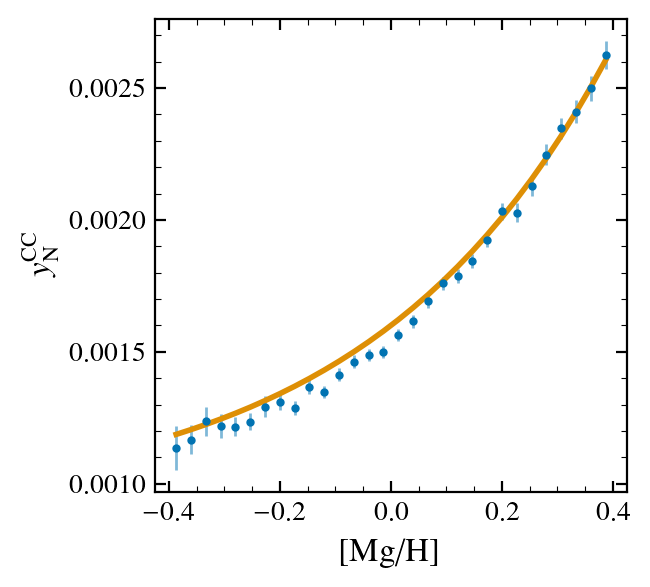

In [28]:
# parameters
sp = arya.Subplot()
y_o_cc = 0.015

y_n = y_o_cc*aah.bracket_to_abundance(n_o, "N", "O")
y_n_err = y_n * np.log(10) * n_o_err

y_n_cc = y_n 
a,b,c = plt.errorbar(MoverH, y_n_cc, y_n_err, fmt="o", capsize=0, ms=2)

c[0].set_alpha(0.5)

# plt.scatter(all_dat["[o/h]"], all_dat.y_c, s=1)

popt, covt = curve_fit(mod_n, MoverH, y_n_cc)
 
plt.plot(MoverH, y_agb_n(MoverH)+y_cc_n0, lw=2)

# plt.plot(MoverH, mod_n(MoverH, *popt), zorder=4, lw=2)
plt.xlabel("[Mg/H]")
plt.ylabel(r"$y_{\rm N}^{\rm CC}$")
sp.save("analytic_n.pdf")

In [130]:
print(popt)

[0.0009623  0.00057557]


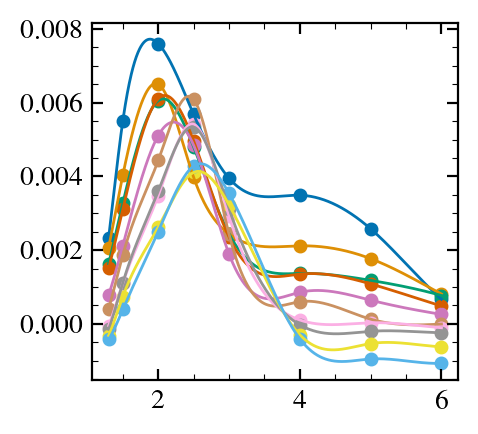

In [15]:
for i in range(len(z1)):
    
    def m_model(m):
        cs = CubicSpline([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
        return cs(m) * ( (m > 1) & (m < 7))
        
    x = np.linspace(1.3, 6, 1000)
    y =m_model(x)
    plt.plot(x, y)
    plt.scatter(m1, [a[i] for a in y1])

In [18]:
y_c_agb1 = []
for i in range(len(z1)):
    def m_model(m):
        cs = interp1d([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
        return cs(m) * ( (m > 1.3) & (m < 6))
    norm = quad(lambda m: m*vice.imf.kroupa(m), 0.08, 120)[0]
    yc = quad(lambda m: m*m_model(m)* vice.imf.kroupa(m), 1.3, 6)[0]/norm
    y_c_agb1.append(yc)

[-0.00031826  0.00042053]
[2.56664095e-05 2.58029024e-05]


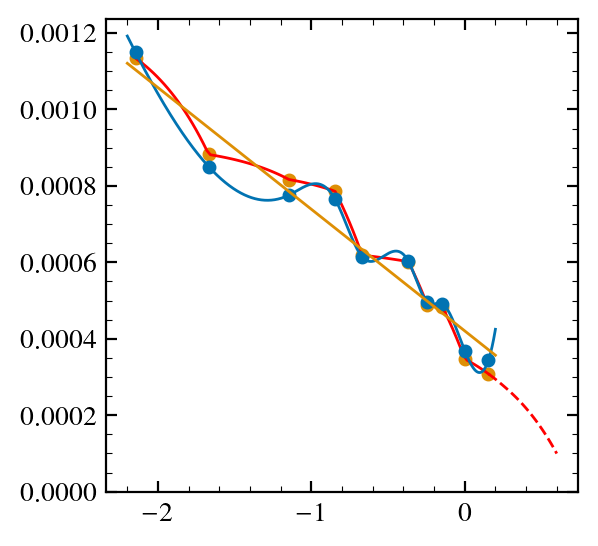

In [19]:
mh1 = np.log10(np.array(z1)/0.014)

cs = CubicSpline(mh1, y_c_agb1)
sp = arya.Subplot()

plt.scatter(mh1, y_c_agb1)

def yc_agb(z):
    return cs(z)
x = np.linspace(-2.2, 0.2, 1000)

def lin(x, a, b):
    return a*x + b

popt, covt = curve_fit(lin, mh1, y_c_agb1)
plt.plot(x, yc_agb(x))
plt.plot(x, lin(x, *popt))
plt.ylim(0)
print(popt)
print(np.diag(covt)**0.5)





vice.yields.agb.settings["c"] = "cristallo11"
vice.yields.ccsne.settings["c"] = 0
Zs = 0.014*10**np.linspace(-2, 1, 100)
model = "cristallo11"
    
    # plots importaint points
y1, m1, z1 = vice.yields.agb.grid('c', study=model)
Zs = np.array(z1)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
        
y_c_agb = np.array(mass_yields)/1e6 
y_o_cc = 0.015
arya.Scatter(np.log10(Zs/0.014), y_c_agb, subplot=sp, zorder=4-i)
    
    
MoverH_min = np.log10(min(Zs)/0.014)
MoverH_max = np.log10(max(Zs)/0.014)
    
Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])

l = arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), 
              subplot=sp, zorder=4-i, color="red")

Zs = 0.014*10**np.linspace(-2.1, MoverH_min, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
          color=l.color, subplot=sp, zorder=4-i)

Zs = 0.014*10**np.linspace(MoverH_max, 0.6, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
          color=l.color, subplot=sp, zorder=4-i)

0.0001
0.0003
0.001
0.002
0.003
0.006
0.008
0.01
0.014
0.02


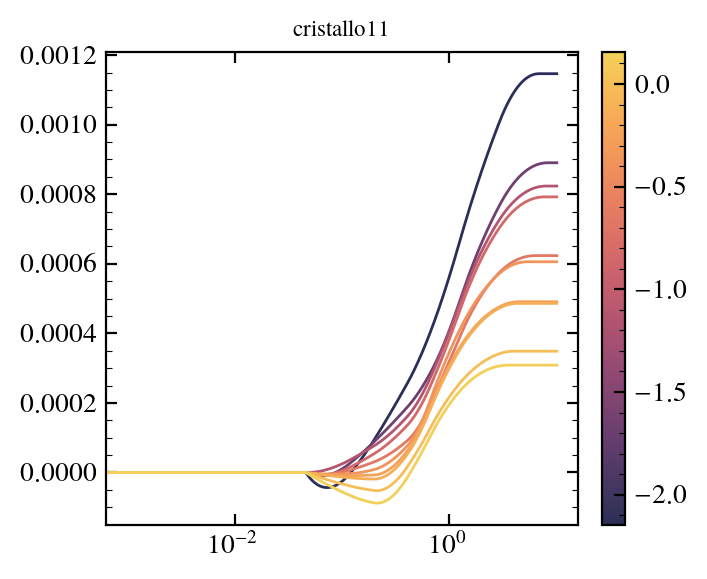

0.0001
0.004
0.008
0.02


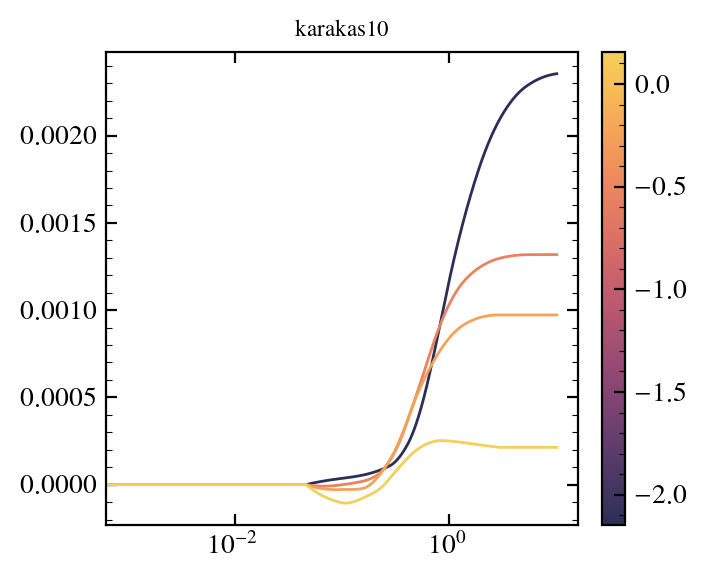

0.0003
0.001
0.002
0.004
0.008
0.014
0.04


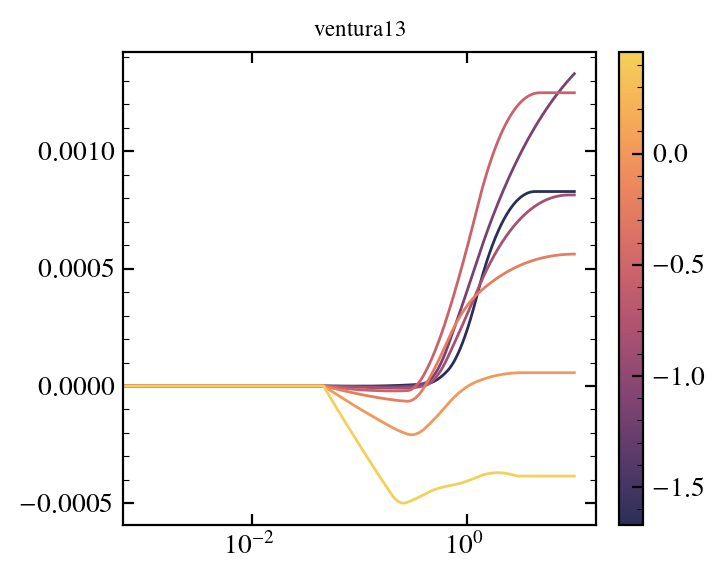

0.0028
0.007
0.014
0.03


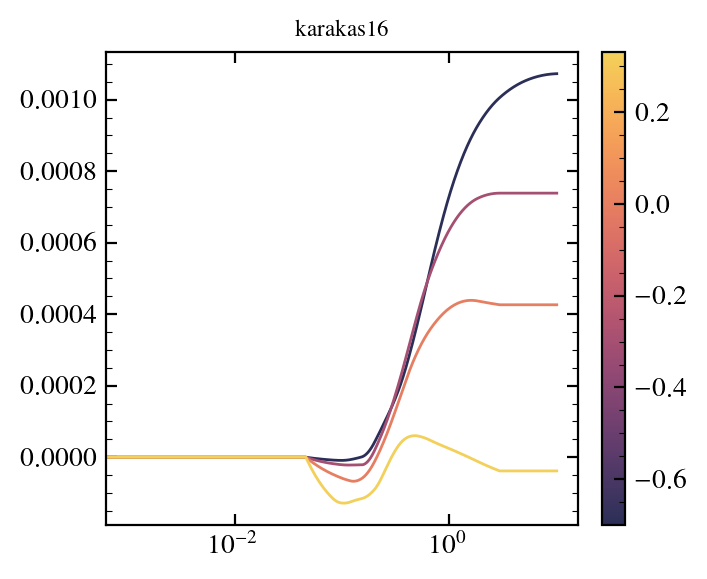

In [27]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
cmap = arya.style.get_cmap()



model = "cristallo11"

for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)
    logZ_min = np.log10(min(z1)/0.014)
    logZ_max = np.log10(max(z1)/0.014)

    norm = mpl.colors.Normalize(logZ_min, logZ_max)

    mpp = mpl.cm.ScalarMappable(norm, cmap)
    ma = mpp.to_rgba

    sp = arya.Subplot()
    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    for i in range(len(z1)):
        z = z1[i]
        vice.yields.agb.settings["c"] = model
        m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
        m_c = [c for c in m_c]
        print(z)

        l = arya.Line(times, np.array(m_c)/1e6, color=ma(np.log10(z/0.014)), subplot=sp)



    arya.Colorbar(subplot=sp, mappable=mpp)
    plt.show()

0.0001
0.0003
0.001
0.002
0.003
0.006
0.008
0.01
0.014
0.02


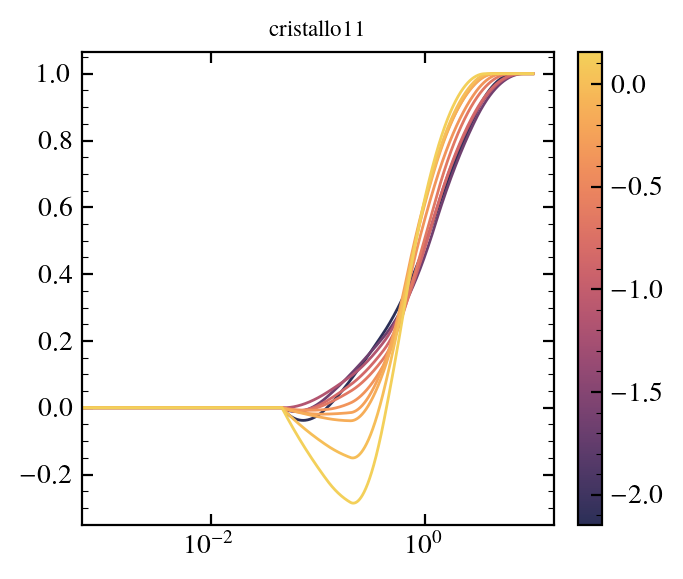

0.0001
0.004
0.008
0.02


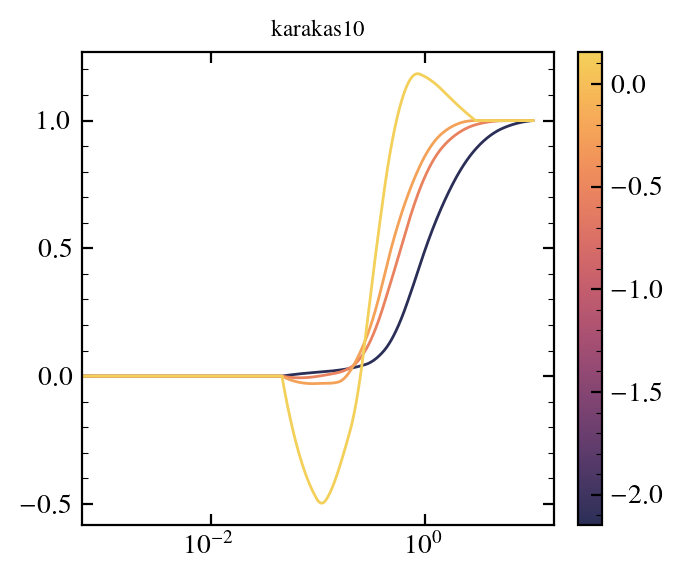

0.0003
0.001
0.002
0.004
0.008
0.014
0.04


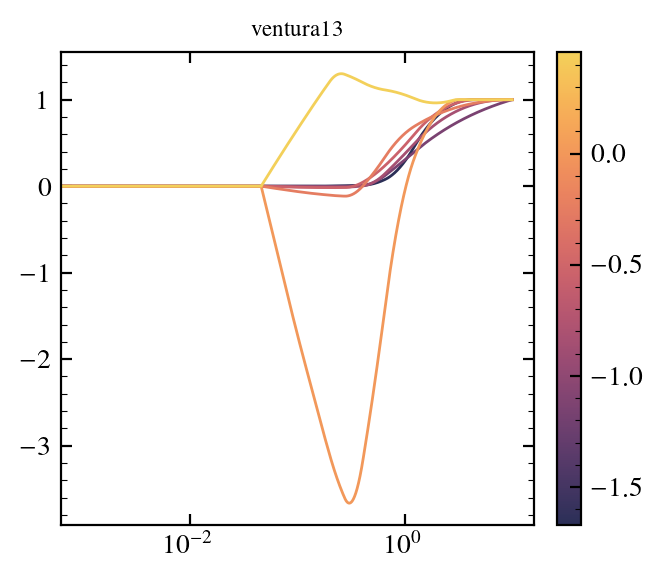

0.0028
0.007
0.014
0.03


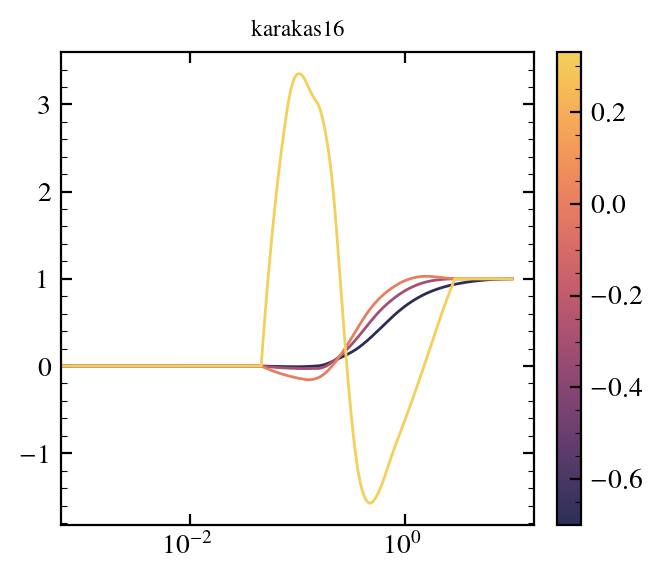

In [26]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
cmap = arya.style.get_cmap()



model = "cristallo11"

for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)
    logZ_min = np.log10(min(z1)/0.014)
    logZ_max = np.log10(max(z1)/0.014)

    norm = mpl.colors.Normalize(logZ_min, logZ_max)

    mpp = mpl.cm.ScalarMappable(norm, cmap)
    ma = mpp.to_rgba

    sp = arya.Subplot()
    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    for i in range(len(z1)):
        z = z1[i]
        vice.yields.agb.settings["c"] = model
        m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
        m_c = [c for c in m_c]
        print(z)

        l = arya.Line(times, np.array(m_c)/m_c[-1], color=ma(np.log10(z/0.014)), subplot=sp)



    arya.Colorbar(subplot=sp, mappable=mpp)
    plt.show()

In [ ]:
def y_agb(MoverH):
    return vice.ya

In [38]:
def calc_y_c_cc(y_agb_a, y_o_cc=0.015):
    y_c_cc =y_o_cc*aah.bracket_to_abundance(c_o[filt], "C", "O") - y_agb_a[filt]
    y_c_cc_err = y_c_cc * c_o_err[filt] * np.log(10)
    return y_c_cc, y_c_cc_err

In [23]:
def plot_model(y_agb_a, **kwargs):
    y_c_cc, _ = calc_y_c_cc(y_agb_a)
    plt.plot(MoverH[filt], y_c_cc, **kwargs)

In [24]:
def compare_y_c_cc(y_agb_a):
    plot_model(y_agb_a)
    y_c_cc_model = fit_model(y_agb_a)(Z[filt])
    plt.errorbar(MoverH[filt], y_c_cc_model)

    plt.xlabel("[M/H]")
    plt.ylabel("y carbon core collapse")

Above, solid lines are the fitted curves and the squigly lines are the value of y_c_cc calculated at each \[M/H\]

In [27]:
def plot_f_agb(y_agb_a):
    y_c_cc, _ = calc_y_c_cc(y_agb_a)
    plt.plot(MoverH[filt], y_agb_a[filt]/(y_c_cc+y_agb_a[filt]))

In [28]:
def compare_f_agb(y_agb_a):
    plot_f_agb(y_agb_a)

    plt.xlabel("[M/H]")
    plt.ylabel("f agb")
    plt.scatter(0, 0.2, marker="*", s=200, c="orange")
    #plt.ylim(-1)


In [29]:
from scipy.optimize import curve_fit

0.003763657973465769
model: y_c^cc = (0.0038 +- 0.00008) + (0.007 +- 0.0002})*Z
one file saved at ./analytic.pdf


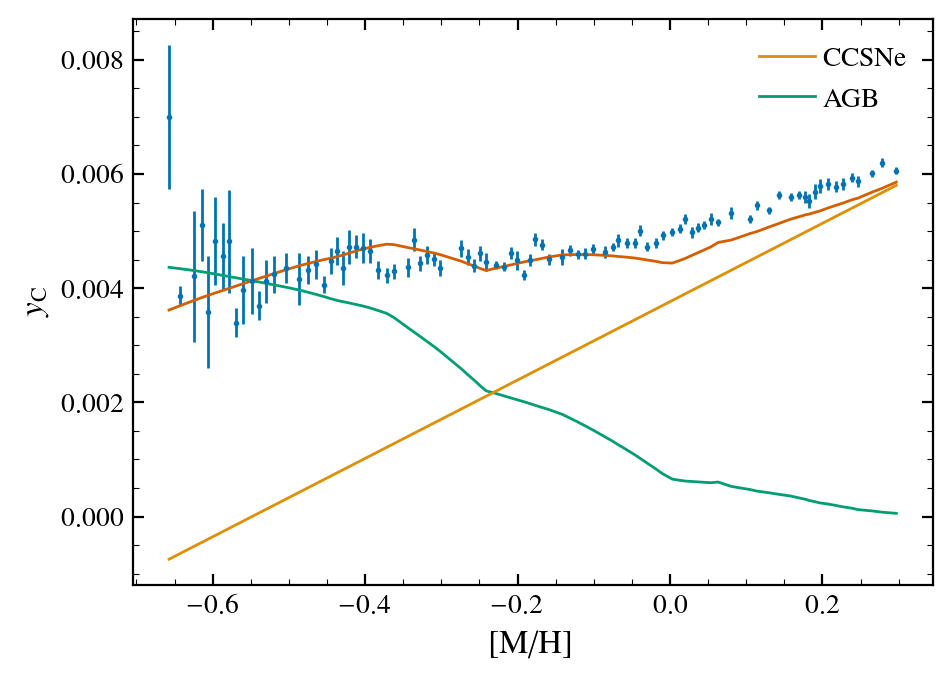

In [47]:

yagb = y_agb_a["cristallo11"] * 3

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plt.sca(axs[0])
y_c, y_c_err = calc_y_c_cc(0*yagb)

sp = arya.Subplot()
y_c_cc, y_c_cc_err = calc_y_c_cc(yagb)
plt.errorbar(MoverH[filt], y_c, yerr=y_c_err, fmt="o", ms=1, capsize=0)
y_c_cc_model = fit_model(yagb)(Z[filt])
plt.plot(MoverH[filt], y_c_cc_model, zorder=3, label="CCSNe")
plt.plot(MoverH[filt], yagb[filt], label="AGB")
plt.plot(MoverH[filt], yagb[filt] + y_c_cc_model)

plt.xlabel("[M/H]")
plt.ylabel(r"$y_{\rm C}$")
plt.legend()


# plt.sca(axs[1])

# plt.plot(*calc_equlibrium(yagb), label="1", lw=3, color="red")

# plt.scatter(df["FE_H"], df["C_O"], s=1, color="k")
# plt.xlabel("[O/H]")
# plt.ylabel("[C/O]")
# plt.xlim(-0.7, 0.6)
# plt.ylim(-0.6, 0.5)


# plt.tight_layout()


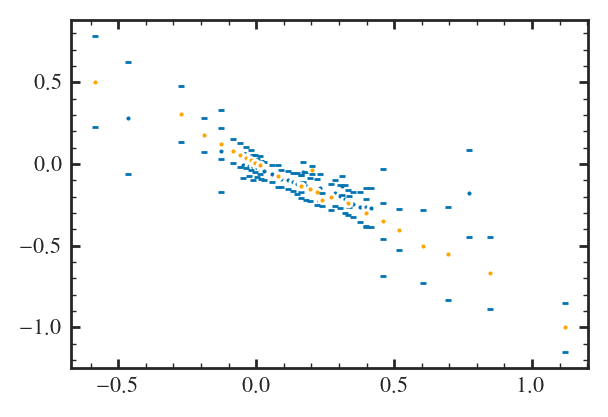

In [17]:
arya.binnedplot(aah.subgiants, x="MG_FE", y="C_MG")
arya.binnedplot(aah.subgiants, x="O_FE", y="C_O", facecolor="orange")

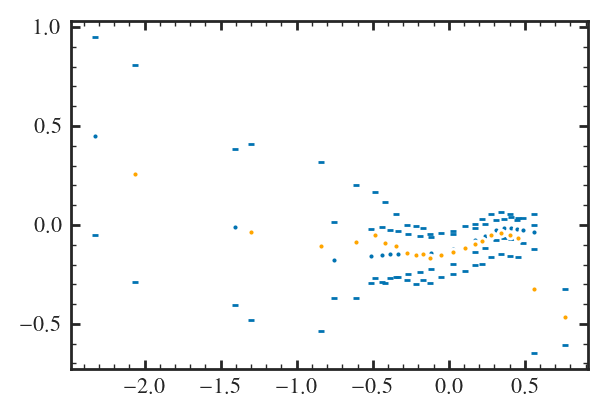

In [18]:
arya.binnedplot(aah.subgiants, x="MG_H", y="C_MG")
arya.binnedplot(aah.subgiants, x="O_H", y="C_O", facecolor="orange")

Text(0, 0.5, '[n/o]')

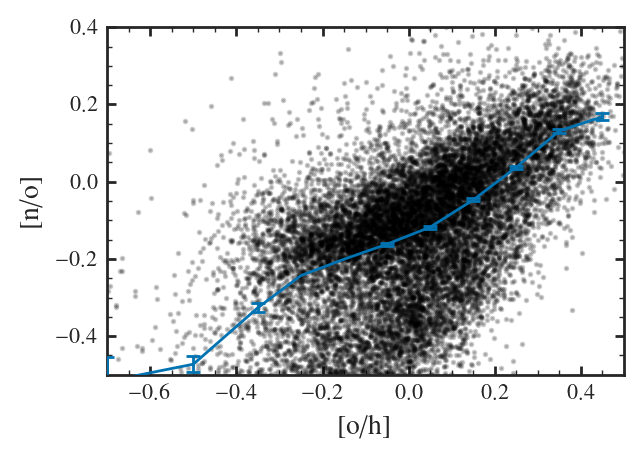

In [93]:
plt.errorbar(MoverH, n_o, yerr=n_o_err, zorder=5)
plt.scatter(subgiants.MG_H, subgiants["N_MG"], s=1, color="k", alpha=0.2)

plt.xlim(-0.7, 0.5)
plt.ylim(-0.5, 0.4)
plt.xlabel("[o/h]")
plt.ylabel("[n/o]")